<img src="https://pbs.twimg.com/profile_images/1354934581900816394/g0_FLaCP_400x400.jpg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px; width:160px" />

# r/WallStreetBets Stock Sentiment

**Project by**: Ignacio Chavarria (@ignacio_chr | www.linkedin.com/in/ignacio-chavarria)

This script helps you:
 - **Find the top X submissions and Y comments for a set of tickers in the past day, week, month, year, or all time.** In this example we are using the top 50 submissions and the top 1000 comments per ticker in the past day. You can easily edit this in the script.
 - **Assess the sentiment of those submissions and comments.** In this example, for each submission and comment, we are assesing the sentiment based on whether the text contains words related to "buy", "hold" or "sell".
 - **Observe the leading sentiment for each stock, based on user comentary on a Reddit subreddit.** In this example, we are using r/WallStreetBets
 
*Disclaimer: This script is not meant to be used for trading.*

#### **Notebook sections**:
1. [Main Inputs](#Main-Inputs)
2. [Stock sentiment, by keyword frequencies](#Stock-sentiment,-by-keyword-frequencies)
3. [Stock sentiment, by keywords and upvotes](#Stock-sentiment,-by-keywords-and-upvotes)
4. [Top buy, hold, and sell comments](#Top-buy,-hold,-and-sell-comments)
5. [Top 3 submissions](#Top-3-submissions)

# Main Inputs
This section shows the script's main inputs, which you can edit below to create a customized analysis.

In [111]:
reddit_client_id=""
reddit_client_secret=""
reddit_user_agent=""

In [112]:
tickers = ['GME','AMC']

In [113]:
submissions_per_ticker = 50

In [114]:
comments_per_submission = 20

In [115]:
subreddit_name = 'wallstreetbets'

In [116]:
bullish_terms = ['buy','buying','bull','bullish']
bearish_terms = ['sell','selling','dump','bear','bearish']
neutral_terms = ['hold','holding','hodl','diamond','💎']

# Stock sentiment, by keyword frequencies
The output of this first section will be 1 graph for every ticker, containing a bar chart with 3 columns representing the count of comments with "Buy", "Hold" and, "Sell" sentiment.

In [117]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [118]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


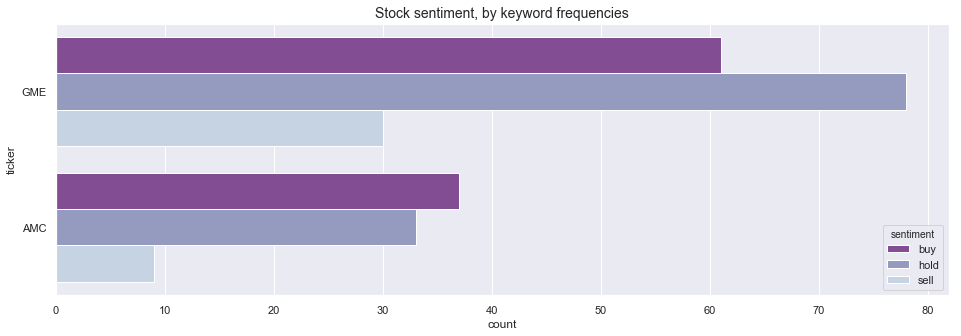

In [119]:
import praw
import datetime as dt
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
from datetime import date
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

reddit = praw.Reddit(
     client_id=reddit_client_id,
     client_secret=reddit_client_secret,
     user_agent=reddit_user_agent
)

subreddit = reddit.subreddit(subreddit_name)

top_subs = [subreddit.search([ticker],limit=submissions_per_ticker,time_filter="day",sort="top") for ticker in tickers]

topics_dict = { "ticker":[],
                "title":[],
                "score":[],
                "id":[], 
                "url":[],
                "comms_num": [],
                "created": [],
                "body":[]}

for x in range(len(tickers)):
    for submission in top_subs[x]:
        topics_dict["ticker"].append(tickers[x])
        topics_dict["title"].append(submission.title)
        topics_dict["score"].append(submission.score)
        topics_dict["id"].append(submission.id)
        topics_dict["url"].append(submission.url)
        topics_dict["comms_num"].append(submission.num_comments)
        topics_dict["created"].append(submission.created)
        topics_dict["body"].append(submission.selftext)
        
topics_data = pd.DataFrame(topics_dict)

def get_date(created):
    return dt.datetime.fromtimestamp(created)

_timestamp = topics_data["created"].apply(get_date)
topics_data = topics_data.assign(timestamp = _timestamp)

comments_dict = { "ticker":[],
                  "body":[],
                  "score":[], 
                  "created": [],
                  "submission": [],
                  "id":[]}

for x in range(len(topics_dict["id"])):
    
    sub = reddit.submission(topics_dict["id"][x])
    
    sub.comment_sort = "top"
    sub.comment_limit = comments_per_submission
    sub.comments.replace_more(limit=0)
    
    for comment in sub.comments.list():
        comments_dict['ticker'].append(topics_data['ticker'][x])
        comments_dict['score'].append(comment.score)
        comments_dict['id'].append(comment.id)
        comments_dict['created'].append(comment.created_utc)
        comments_dict['body'].append(comment.body)
        comments_dict['submission'].append(comment.submission)
        
df1 = pd.DataFrame(comments_dict)

del df1['id']
del df1['created']
del df1['submission']

buy_wrds = bullish_terms
sell_wrds = bearish_terms
hold_wrds = neutral_terms

df1['buy'] = 0
df1['hold'] = 0
df1['sell'] = 0
df1['unique'] = 0

df1['body'] = df1['body'].apply(lambda x: x.lower())

for n in range(len(df1['body'])):
    for wrd in df1['body'][n].split():
        if wrd in buy_wrds:
            df1['buy'][n] = 1
        if wrd in sell_wrds:
            df1['sell'][n] = 1
        if wrd in hold_wrds:
            df1['hold'][n] = 1
            
for n in range(len(df1['body'])):
    df1['unique'][n] = df1['buy'][n].item() + df1['hold'][n].item() + df1['sell'][n].item()
    
df2 = df1.loc[df1['unique'] == 1].reset_index().drop('index',1).drop('unique',1)

df2['sentiment'] = ''

for n in range(len(df2['body'])):
    if df2['buy'][n] == 1:
        df2['sentiment'][n] = 'buy'
    elif df2['hold'][n] == 1:
        df2['sentiment'][n] = 'hold'
    else:
        df2['sentiment'][n] = 'sell'

df3 = df2.drop(['buy','hold','sell'],1)

sns.set(rc={'figure.figsize':(16,5)})
ax = sns.countplot(y="ticker", hue="sentiment", hue_order= ['buy','hold','sell'], data=df3, palette='BuPu_r').set_title("Stock sentiment, by keyword frequencies", fontsize=14)

# Stock sentiment, by keywords and upvotes
The following graphs show, for each ticker, the sum of upvotes for comments with "buy", "hold", and "sell" sentiment.

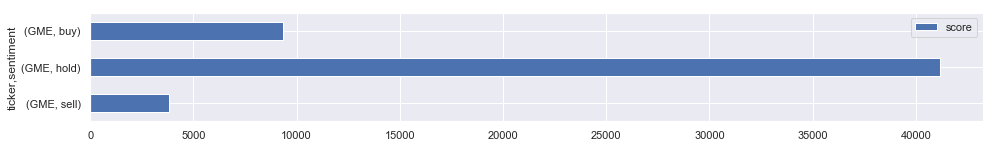

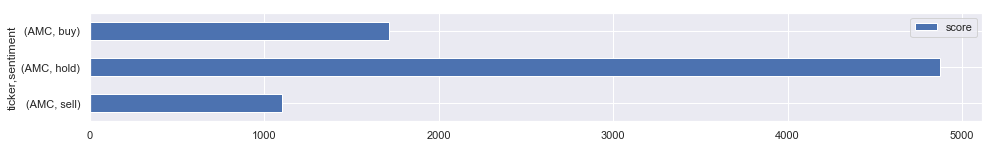

In [120]:
sns.set(rc={'figure.figsize':(16,2)})

for ticker in tickers:
    df3.loc[df3['ticker'] == ticker].groupby(['ticker','sentiment']).sum().plot(kind="barh").invert_yaxis()

# Top buy, hold, and sell comments
The comments shown below are the highest upvoted from the last day, for each sentiment category. These comments were posted under submissions that mentioned the desired ticker(s) in either the title or body.

In [132]:
pd.options.display.max_colwidth = 225

for ticker in tickers:
    print("\n" + "Ticker: " + ticker + "\n")
    for x in ['buy','sell','hold']:
        print("Top " + x + " comment:")
        print(df3.loc[(df3['ticker'] == ticker) & (df3['sentiment'] == x)].sort_values(by='score', ascending=False)[0:1]['body'].to_string(index=False))
        print("Upvotes: " + df3.loc[(df3['ticker'] == ticker) & (df3['sentiment'] == x)].sort_values(by='score', ascending=False)[0:1]['score'].to_string(index=False))
        print("\n")


Ticker: GME

Top buy comment:
 the finger snap is robinhood not letting more people buy shares
Upvotes:  4120


Top sell comment:
 imagine watching the movie and dfv and micheal bury make millions at the end of the ultimate short squeeze and your dumb ass sold for a loss lol...i’m not selling
Upvotes:  1023


Top hold comment:
 everyones got proof every day with this shit. we’ve lost momentum just hold and pray for valhalla.
Upvotes:  6831



Ticker: AMC

Top buy comment:
 yea people don't realize there was never a squeeze with bb its just a great buy
Upvotes:  302


Top sell comment:
 it took me 2 decades to learn how to read, i sure as hell haven't learnt how to sell yet 🚀🚀💎
Upvotes:  632


Top hold comment:
 til that covering 40 million shares while there is a shortage of shares decreases the price of a stock by 90%. i will short the fuck out of every thing now. \n\nfuck you, im holding
Upvotes:  1048




# Top 3 submissions per ticker, by upvotes
The submissions below are the highest upvoted from the past day. The desired ticker is either mentioned in the title or the body of the submissions.

In [133]:
pd.options.display.max_colwidth = 225

for ticker in tickers:
    print("Ticker: " + ticker + "\n")
    print("Top 3 submissions:")
    
    print(topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[0:1]['title'].to_string(index=False))
    print("Upvotes: " + topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[0:1]['score'].to_string(index=False))
    print("URL: " + topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[0:1]['url'].to_string(index=False))    
    print("\n")
    
    print(topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[1:2]['title'].to_string(index=False))
    print("Upvotes: " + topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[1:2]['score'].to_string(index=False))
    print("URL: " + topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[1:2]['url'].to_string(index=False))    
    print("\n")
    
    print(topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[2:3]['title'].to_string(index=False))
    print("Upvotes: " + topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[2:3]['score'].to_string(index=False))
    print("URL: " + topics_data.loc[(topics_data['ticker'] == ticker)].sort_values(by='score', ascending=False)[2:3]['url'].to_string(index=False))    
    print("\n")

Ticker: GME

Top 3 submissions:
 WSB: GME Infinity War
Upvotes:  58934
URL:  https://v.redd.it/h02i6340agg61


 How I was acting with my boss holding my 100 GME when it peaked at $483
Upvotes:  22391
URL:  https://v.redd.it/52fwvtpzzgg61


 Welcome to the battle
Upvotes:  19194
URL:  https://www.reddit.com/r/wallstreetbets/comments/lg5ew0/welcome_to_the_battle/


Ticker: AMC

Top 3 submissions:
 GME and AMC are dead, and here's why.
Upvotes:  4589
URL:  https://www.reddit.com/r/wallstreetbets/comments/lghuem/gme_and_amc_are_dead_and_heres_why/


 Starting to think AMC might not go to $420.69
Upvotes:  2989
URL:  https://www.reddit.com/r/wallstreetbets/comments/lg6nf1/starting_to_think_amc_might_not_go_to_42069/


 Daddy's DD of the week: $BB
Upvotes:  2060
URL:  https://www.reddit.com/r/wallstreetbets/comments/lg4gx4/daddys_dd_of_the_week_bb/


